<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/dip_prediction_from_ecoscope_LWD_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up

In [ ]:
!git clone https://github.com/yohanesnuwara/formation-evaluation
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'formation-evaluation'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 120 (delta 53), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (120/120), 8.05 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Cloning into 'geostatistics'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 230 (delta 35), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (230/230), 58.89 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install -q dlisio
# !pip install -q geostatspy
import dlisio
# import geostatspy.geostats as geostats  

import sys
sys.path.append("/content/formation-evaluation")
from merge_data import merge_data_interpolation

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, QuantileTransformer, normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.style.use("classic")

     |████████████████████████████████| 440kB 6.8MB/s 


In [ ]:
# Unzip file
!pip install unrar
!unrar x "/content/geostatistics/data/volve-realtime/well_15_9_F-14/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/geostatistics/data/volve-realtime/well_15_9_F-14/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.rar

Extracting  WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS                    16% 32% 49% 65% 81% 98% 99%  OK 
All OK


## Load Ecoscope data

In [ ]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f, *f_tail = dlisio.load(filename)

# Retrieve TDEP channel. Note: TDEP is Tool Depth (MD) not True Vert. Depth (TVD)
TDEP_chan = f.object('CHANNEL', 'TDEP', origin=41, copynr=0)

# Extract TDEP to array and convert from 0.1 inch to M unit
TDEP = TDEP_chan.curves() * 2.54E-3

# Initialize dataframe with TDEP
lwd_df = pd.DataFrame({"TDEP": TDEP})

# Retrieve logs channel
features = ["RLSC", "RSSC", "PESC", "USC"]
RLSC_chan = f.object('CHANNEL', 'RLSC')
RSSC_chan = f.object('CHANNEL', 'RSSC')
PESC_chan = f.object('CHANNEL', 'PESC')
USC_chan = f.object('CHANNEL', 'USC')

channels = [RLSC_chan, RSSC_chan, PESC_chan, USC_chan]

# Put all logs into dataframe
for i in range(4):
  data = channels[i].curves()
  for j in range(16):
    az = data[:,j]
    colname = features[i] + "[" + np.str(j) + "]"
    lwd_df[colname] = az

# Remove Null values (-999) and depth < 2,790 M
lwd_df = lwd_df[(lwd_df > -998)]
lwd_df = lwd_df[(lwd_df["TDEP"] > 2790)]
lwd_df = lwd_df.dropna(axis=0).reset_index(drop=True)

lwd_df.head(10)

,TDEP,RLSC[0],RLSC[1],RLSC[2],RLSC[3],RLSC[4],RLSC[5],RLSC[6],RLSC[7],RLSC[8],RLSC[9],RLSC[10],RLSC[11],RLSC[12],RLSC[13],RLSC[14],RLSC[15],RSSC[0],RSSC[1],RSSC[2],RSSC[3],RSSC[4],RSSC[5],RSSC[6],RSSC[7],RSSC[8],RSSC[9],RSSC[10],RSSC[11],RSSC[12],RSSC[13],RSSC[14],RSSC[15],PESC[0],PESC[1],PESC[2],PESC[3],PESC[4],PESC[5],PESC[6],PESC[7],PESC[8],PESC[9],PESC[10],PESC[11],PESC[12],PESC[13],PESC[14],PESC[15],USC[0],USC[1],USC[2],USC[3],USC[4],USC[5],USC[6],USC[7],USC[8],USC[9],USC[10],USC[11],USC[12],USC[13],USC[14],USC[15]
0,2790.139160,2.327354,2.372438,2.401770,2.443717,2.491113,2.524036,2.530610,2.521511,2.524608,2.504921,2.481642,2.440911,2.398883,2.376613,2.340244,2.329477,1.982702,2.069338,2.162192,2.272110,2.406690,2.488485,2.516123,2.506254,2.507730,2.438496,2.328745,2.214675,2.113122,2.033007,1.966792,1.920846,9.252029,8.379761,7.698917,6.787434,5.593493,4.939641,4.725202,4.822330,4.748707,5.233131,6.015181,7.134624,7.852172,8.481730,9.196815,9.541833,23.304440,21.249212,19.482933,17.233341,14.231839,12.605275,12.037434,12.245759,12.076427,13.338527,15.436159,18.271225,20.030977,21.748680,23.460651,24.514023
1,2790.291504,2.343065,2.376542,2.409086,2.451166,2.493644,2.516037,2.528741,2.524522,2.520093,2.497989,2.471005,2.434862,2.398129,2.375579,2.339770,2.345492,1.981876,2.082503,2.174005,2.286952,2.402723,2.489347,2.508785,2.504105,2.502522,2.415274,2.309173,2.192167,2.107954,2.022535,1.957225,1.933982,9.281882,8.337337,7.611905,6.613083,5.539487,4.887945,4.842068,4.810463,4.805316,5.440555,6.257687,7.344736,8.012337,8.599115,9.451885,9.627559,23.620029,21.131786,19.298607,16.815147,14.124071,12.415416,12.340052,12.241661,12.201799,13.873364,16.020903,18.824598,20.452843,22.095406,24.172077,24.902531
2,2790.444092,2.338008,2.367054,2.411191,2.450691,2.491581,2.503623,2.526684,2.522599,2.521058,2.487008,2.449215,2.425350,2.379540,2.359445,2.327754,2.345019,1.949788,2.045356,2.141410,2.285412,2.373950,2.481403,2.502526,2.496126,2.487805,2.390593,2.276562,2.166309,2.080155,1.990495,1.914942,1.925800,9.534317,8.675117,7.814491,6.703969,5.753050,5.059204,4.915812,4.897995,4.998516,5.657558,6.602788,7.507107,8.297067,8.968920,9.797839,9.924447,24.409441,22.048162,19.959841,17.046417,14.727022,12.780452,12.528888,12.470440,12.735955,14.404252,16.801487,19.233616,21.077358,23.010571,25.191872,25.734598
3,2790.596436,2.327120,2.370285,2.404990,2.452779,2.492657,2.505756,2.517955,2.524580,2.516444,2.481610,2.449802,2.417019,2.369291,2.348548,2.314953,2.321317,1.944039,2.032608,2.140607,2.271674,2.341151,2.431107,2.461585,2.472701,2.445853,2.351373,2.247999,2.158714,2.069842,1.972947,1.904765,1.904069,9.563367,8.583584,7.753132,6.639790,5.952930,5.376728,5.205581,5.074896,5.369811,5.960997,6.789444,7.515501,8.374217,9.163350,9.852172,9.938733,24.348112,21.926271,19.737089,16.942522,15.334025,13.729474,13.306854,12.993274,13.755236,15.237281,17.368082,19.193888,21.193455,23.461027,25.191002,25.533794
4,2790.748779,2.333624,2.385849,2.417751,2.459691,2.479612,2.494046,2.504064,2.512179,2.501908,2.469403,2.446259,2.417947,2.376372,2.357618,2.337131,2.330352,1.993075,2.062186,2.186296,2.265360,2.318899,2.369558,2.396581,2.408336,2.393333,2.310374,2.239567,2.189066,2.100333,2.018028,1.975301,1.952185,9.139263,8.264203,7.424596,6.683455,6.282370,5.867125,5.606312,5.434009,5.724523,6.227366,6.851986,7.219608,8.026108,8.788331,9.098657,9.322467,23.049538,21.158693,18.871206,17.136351,16.131514,15.050504,14.391231,13.981198,14.685963,15.926270,17.520472,18.342836,20.265005,22.356041,23.107431,23.727924
5,2790.901123,2.363678,2.405449,2.431597,2.465732,2.475109,2.477762,2.485427,2.498941,2.479978,2.455839,2.460131,2.427423,2.403078,2.384883,2.364949,2.356690,2.067551,2.127668,2.243387,2.269070,2.302239,2.313799,2.326489,2.343327,2.324908,2.268964,2.237095,2.221426,2.152124,2.076349,2.054166,2.029195,8.396537,7.677077,6.930428,6.593058,6.351925,6.282840,6.102057,5.845146,6.209699,6.555860,6.661917,7.001852,7.557605,8.270632,8.418806,8.69090

## Load dip measurement data

In [ ]:
dip_df = pd.read_csv("/content/Statoil_Volve_15_9-F-14_Dips.csv", skiprows=6)

# Dip magnitude, dip azimuth
md, dipmag, dipazi = dip_df.iloc[:,0].values, dip_df.iloc[:,3].values, dip_df.iloc[:,4].values

dip_df = pd.DataFrame({"MD": md, "DIPMAG": dipmag, "DIPAZI": dipazi})

dip_df.head(10)

,MD,DIPMAG,DIPAZI
0,2790.1367,0.63723,115.18244
1,2790.9190,14.45474,339.55316
2,2792.2652,21.94520,353.90387
3,2793.9441,18.34876,331.55826
4,2794.9068,19.67128,329.38260
5,2795.8948,15.65783,335.35577
6,2796.7686,3.47956,317.54980
7,2797.9776,30.83165,17.65056
8,2798.9174,17.91558,347.44510
9,2800.1951,25.73834,332.61636


## Combine Ecoscope data with dip data

In [ ]:
# Make list of feature names
azi = np.arange(16).astype(str)
bracket0, bracket1 = np.full(16,'['), np.full(16,']')

azim = np.linspace(0,360,16)

col_min = [2, 1.8, 0, 0]
col_max = [3, 3, 20, 50]

logs = []
for i in range(len(features)):
  logs_ = []
  for j in range(len(azi)):
    _ = features[i] + bracket0[j] + azi[j] + bracket1[j]
    logs_.append(_)
  logs.append(logs_)

print(logs)

[['RLSC[0]', 'RLSC[1]', 'RLSC[2]', 'RLSC[3]', 'RLSC[4]', 'RLSC[5]', 'RLSC[6]', 'RLSC[7]', 'RLSC[8]', 'RLSC[9]', 'RLSC[10]', 'RLSC[11]', 'RLSC[12]', 'RLSC[13]', 'RLSC[14]', 'RLSC[15]'], ['RSSC[0]', 'RSSC[1]', 'RSSC[2]', 'RSSC[3]', 'RSSC[4]', 'RSSC[5]', 'RSSC[6]', 'RSSC[7]', 'RSSC[8]', 'RSSC[9]', 'RSSC[10]', 'RSSC[11]', 'RSSC[12]', 'RSSC[13]', 'RSSC[14]', 'RSSC[15]'], ['PESC[0]', 'PESC[1]', 'PESC[2]', 'PESC[3]', 'PESC[4]', 'PESC[5]', 'PESC[6]', 'PESC[7]', 'PESC[8]', 'PESC[9]', 'PESC[10]', 'PESC[11]', 'PESC[12]', 'PESC[13]', 'PESC[14]', 'PESC[15]'], ['USC[0]', 'USC[1]', 'USC[2]', 'USC[3]', 'USC[4]', 'USC[5]', 'USC[6]', 'USC[7]', 'USC[8]', 'USC[9]', 'USC[10]', 'USC[11]', 'USC[12]', 'USC[13]', 'USC[14]', 'USC[15]']]


In [ ]:
# Integrate data
df_data, df_new = lwd_df, dip_df 
xdata, xnew = "TDEP", "MD"
ydata = np.ndarray.flatten(np.array(logs))

# Combine trajectory and drilling data into new dataframe
df = merge_data_interpolation(df_data, df_new, xdata, ydata, xnew)

df.head()

,MD,DIPMAG,DIPAZI,RLSC[0],RLSC[1],RLSC[2],RLSC[3],RLSC[4],RLSC[5],RLSC[6],RLSC[7],RLSC[8],RLSC[9],RLSC[10],RLSC[11],RLSC[12],RLSC[13],RLSC[14],RLSC[15],RSSC[0],RSSC[1],RSSC[2],RSSC[3],RSSC[4],RSSC[5],RSSC[6],RSSC[7],RSSC[8],RSSC[9],RSSC[10],RSSC[11],RSSC[12],RSSC[13],RSSC[14],RSSC[15],PESC[0],PESC[1],PESC[2],PESC[3],PESC[4],PESC[5],PESC[6],PESC[7],PESC[8],PESC[9],PESC[10],PESC[11],PESC[12],PESC[13],PESC[14],PESC[15],USC[0],USC[1],USC[2],USC[3],USC[4],USC[5],USC[6],USC[7],USC[8],USC[9],USC[10],USC[11],USC[12],USC[13],USC[14],USC[15]
0,2790.1367,0.63723,115.18244,2.326864,2.372080,2.401693,2.443466,2.490935,2.523939,2.530687,2.521318,2.524795,2.504909,2.481424,2.440962,2.398576,2.376389,2.340164,2.329243,1.982120,2.068224,2.161150,2.271745,2.406442,2.488691,2.516521,2.506248,2.507907,2.438983,2.328879,2.214918,2.112789,2.032864,1.966355,1.920578,9.256075,8.389677,7.706536,6.795967,5.598981,4.942905,4.720816,4.823526,4.748017,5.228905,6.014029,7.131053,7.852407,8.483947,9.194695,9.544685,23.311614,21.275045,19.505372,17.253802,14.245036,12.612298,12.025819,12.247456,12.075492,13.326375,15.430721,18.261843,20.029398,21.752175,23.457759,24.519823
1,2790.9190,14.45474,339.55316,2.367655,2.407832,2.434461,2.466473,2.474108,2.475472,2.483105,2.496859,2.477538,2.454791,2.461107,2.428630,2.404839,2.387421,2.368600,2.360939,2.075452,2.135666,2.250326,2.271071,2.303101,2.310865,2.321977,2.338777,2.320977,2.267429,2.239834,2.225817,2.157745,2.084132,2.063851,2.038385,8.328282,7.621573,6.877519,6.571764,6.342642,6.284015,6.107506,5.848386,6.209813,6.545469,6.616282,6.962088,7.516977,8.210810,8.348157,8.628932,21.031543,19.451933,17.440071,16.894768,16.282483,16.122405,15.703662,15.104707,15.922204,16.732373,17.054358,17.675473,19.071743,20.938454,21.147420,21.885214
2,2792.2652,21.94520,353.90387,2.348172,2.374084,2.405386,2.438984,2.463140,2.490030,2.492429,2.491496,2.481836,2.468988,2.441465,2.411952,2.384390,2.367754,2.339112,2.342675,2.039599,2.129838,2.187220,2.297416,2.371795,2.416888,2.433455,2.441887,2.404187,2.366289,2.301737,2.214071,2.122230,2.049521,1.994856,1.989113,8.289977,7.487235,6.841808,6.043283,5.582374,5.130319,4.904885,4.901231,5.105909,5.356833,5.924635,6.700779,7.411786,8.057472,8.520102,8.583185,20.859253,18.770325,17.268963,15.237310,14.075436,13.021334,12.427312,12.391812,12.930976,13.563702,14.946960,16.892504,18.717252,20.466943,21.552275,21.793533
3,2793.9441,18.34876,331.55826,2.366843,2.384841,2.422341,2.430431,2.467081,2.481953,2.500892,2.489388,2.492645,2.490930,2.455598,2.441517,2.395663,2.373057,2.343822,2.344713,2.052698,2.125520,2.190279,2.288006,2.355545,2.426977,2.451304,2.463197,2.470714,2.429065,2.349102,2.273236,2.182309,2.088598,2.034958,2.014001,8.645989,7.888230,6.927211,6.391284,5.636042,5.063395,4.882781,4.775587,4.768530,5.017356,5.490027,6.112252,7.096033,7.803567,8.312822,8.444714,21.933428,19.912603,17.638643,16.066056,14.283082,12.769704,12.387975,12.009950,11.996579,12.712176,13.841632,15.497448,17.830495,19.713305,20.884456,21.332644
4,2794.9068,19.67128,329.38260,2.377212,2.405738,2.454424,2.475985,2.487999,2.503998,2.498545,2.507874,2.494659,2.504895,2.484473,2.476558,2.440625,2.407941,2.378282,2.377655,2.063778,2.145235,2.251745,2.340557,2.384659,2.455885,2.438248,2.457131,2.439770,2.424269,2.391122,2.344985,2.245348,2.127882,2.066194,2.061033,8.265459,7.702399,6.713420,6.001085,5.750696,5.278223,5.317436,5.165256,5.154280,5.232543,5.631844,6.063862,6.870570,7.804726,8.279112,8.350280,21.043696,19.597374,17.205599,15.322484,14.664848,13.402551,13.506321,13.141121,13.059902,13.371462,14.317542,15.475257,17.496508,19.953252,21.082123,21.279884


## Display Ecoscope logs

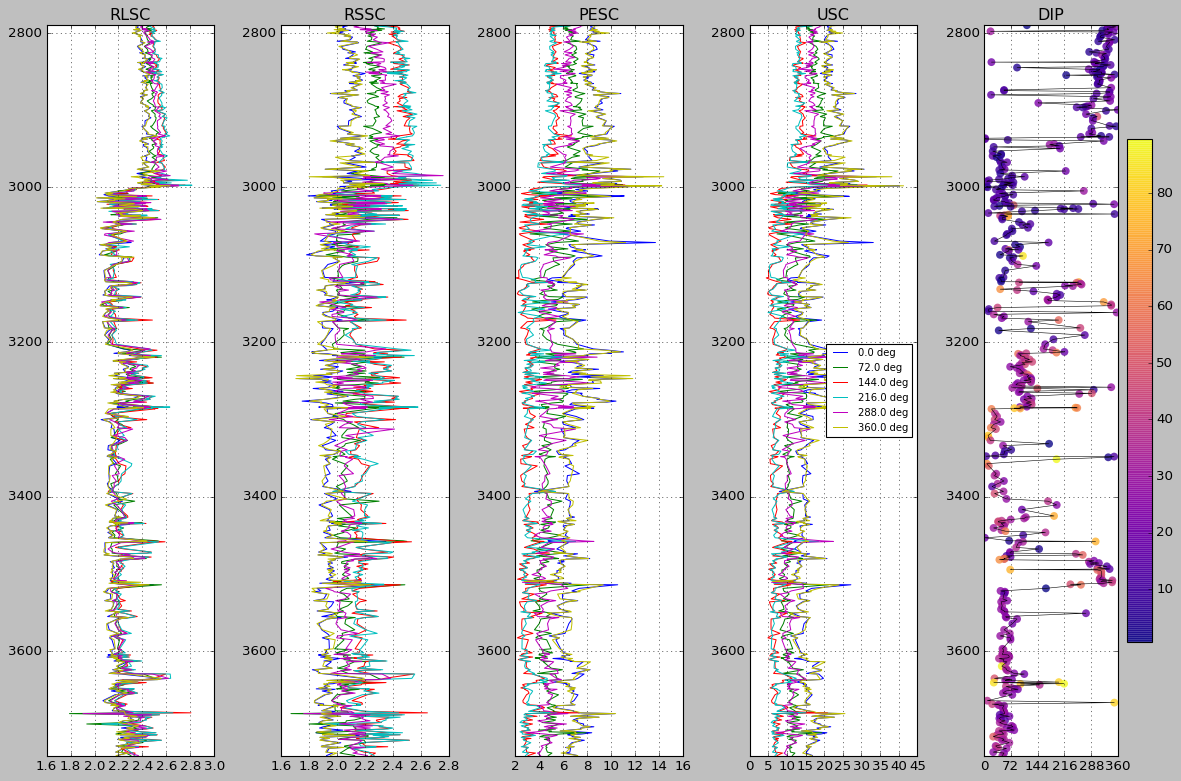

In [ ]:
# Display azimuthal logs
plt.figure(figsize=(15,10))

for i in range(len(logs)):
  x = logs[i]
  plt.subplot(1,5,i+1)
  plt.title(features[i])
  for j in range(0, len(x), 3): # (0,...,1) if no skip, (0,...,2) if skip by 2 azimuths 
    plt.plot(df[x[j]], df["MD"], linewidth=0.9, 
             label="{} deg".format(azim[j]))

  plt.ylim(max(df.MD), min(df.MD))
  # plt.xlim(col_min[i], col_max[i])
  plt.grid()

plt.legend(fontsize=9, loc="center right")

plt.subplot(1,5,5)
plt.plot(df["DIPAZI"], df["MD"], color="black", linewidth=0.5)
plt.scatter(df["DIPAZI"], df["MD"], c=df["DIPMAG"], s=50, cmap="plasma", linewidth=0, alpha=0.8)
plt.colorbar()
plt.title("DIP")
plt.xticks(np.linspace(0, 360, 6))
plt.xlim(0, 360)
plt.ylim(max(df.MD), min(df.MD))
plt.grid()

plt.tight_layout(1.3)
plt.show()

## Visualize boxplot of Ecoscope data azimuths

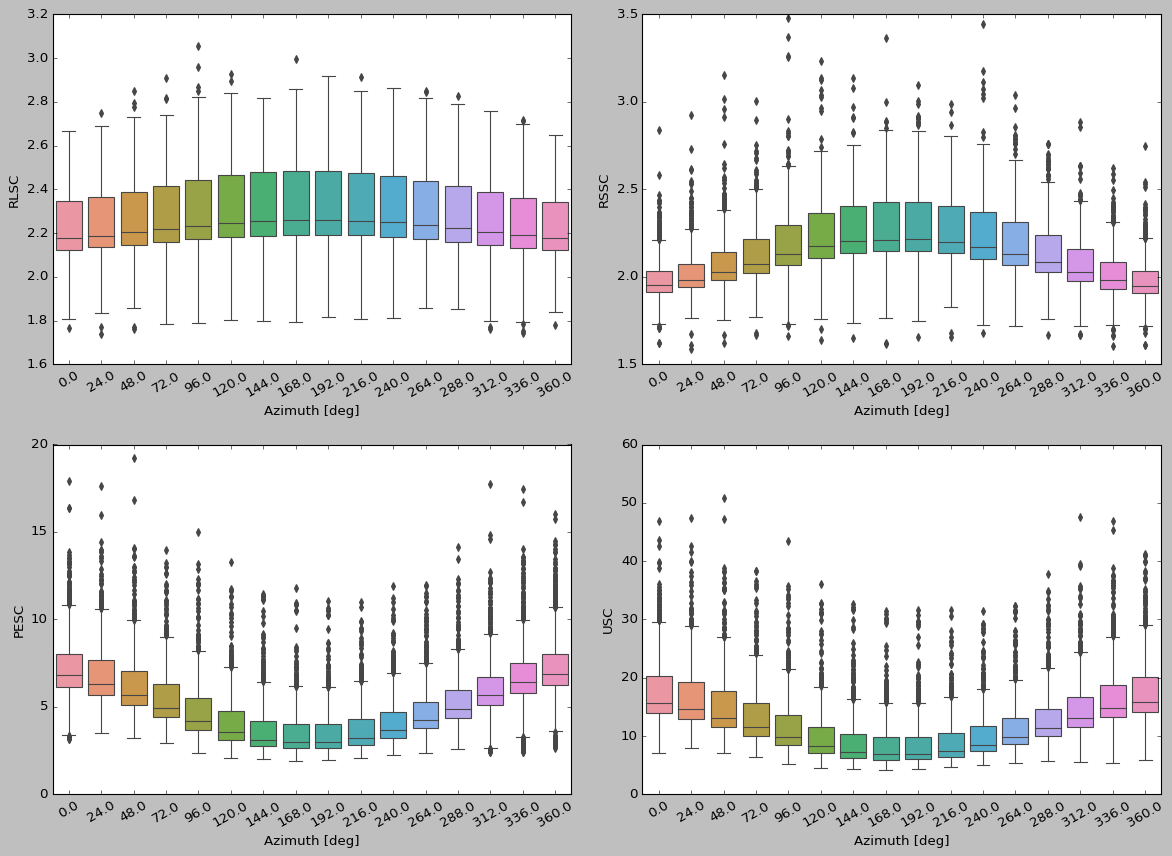

In [ ]:
plt.figure(figsize=(15,11))

# Minimum and maximum y-axis boxplot display
minbox = [1.5, 1, 0, 0]
maxbox = [3, 3, 12, 30]

df_per_logs = []
for i in range(len(logs)):
  df_ = lwd_df[logs[i]]
  # df_per_logs.append(df_)
  plt.subplot(2,2,i+1)
  g = sns.boxplot(x="variable", y="value", data=pd.melt(df_))
  g.set(xlabel="Azimuth [deg]", ylabel=features[i])
  g.set_xticklabels(azim, rotation=30)
  # df_.boxplot()
  # plt.ylim(minbox[i], maxbox[i])

plt.tight_layout(1.5)
plt.show()

## Data transformation

In [ ]:
def nscore2(
    df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0
):
    """GSLIB's NSCORE program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param vcol: name of the variable column
    :param wcol: name of the weight column, if None assumes equal weighting
    :param ismooth: if True then use a reference distribution
    :param dfsmooth: pandas DataFrame required if reference distribution is used
    :param smcol: reference distribution property (required if reference
                  distribution is used)
    :param smwcol: reference distribution weight (required if reference
                   distribution is used)
    :return: TODO
    """
    from geostatspy.geostats import dsortem, gauinv, dlocate, dpowint
    # Set constants
    np.random.seed(73073)
    pwr = 1.0  # interpolation power, hard coded to 1.0 in GSLIB
    EPSILON = 1.0e-20

    # Decide which file to use for establishing the transformation table
    if ismooth:
        nd = len(dfsmooth)
        vr = dfsmooth[smcol].values
        wt_ns = np.ones(nd)
        if smwcol != 0:
            wt_ns = dfsmooth[smwcol].values
    else:
        nd = len(df)
        vr = df[vcol].values
        wt_ns = np.ones(nd)
        if wcol is not None:
            wt_ns = df[wcol].values
    twt = np.sum(wt_ns)

    # Sort data by value
    istart = 0
    iend = nd
    vr, wt_ns = dsortem(istart, iend, vr, 2, wt_ns)

    # Compute the cumulative probabilities and write transformation table
    wtfac = 1.0 / twt
    oldcp = 0.0
    cp = 0.0
    for j in range(istart, iend):
        w = wtfac * wt_ns[j]
        cp = cp + w
        wt_ns[j] = (cp + oldcp) / 2.0
        vrrg = gauinv(wt_ns[j])
        vrg = float(vrrg)
        oldcp = cp

        # Now, reset the weight to the normal scores value
        wt_ns[j] = vrg

    # Normal scores transform
    nd_trans = len(df)
    ns = np.zeros(nd_trans)
    val = df[vcol].values
    for i in range(0, nd_trans):
        vrr = val[i] + np.random.rand() * EPSILON

        # Now, get the normal scores value for "vrr"
        j = dlocate(vr, 1, nd, vrr)
        j = min(max(1, j), (nd - 1))
        ns[i] = dpowint(vr[j], vr[j + 1], wt_ns[j], wt_ns[j + 1], vrr, pwr)

    return ns, vr, wt_ns

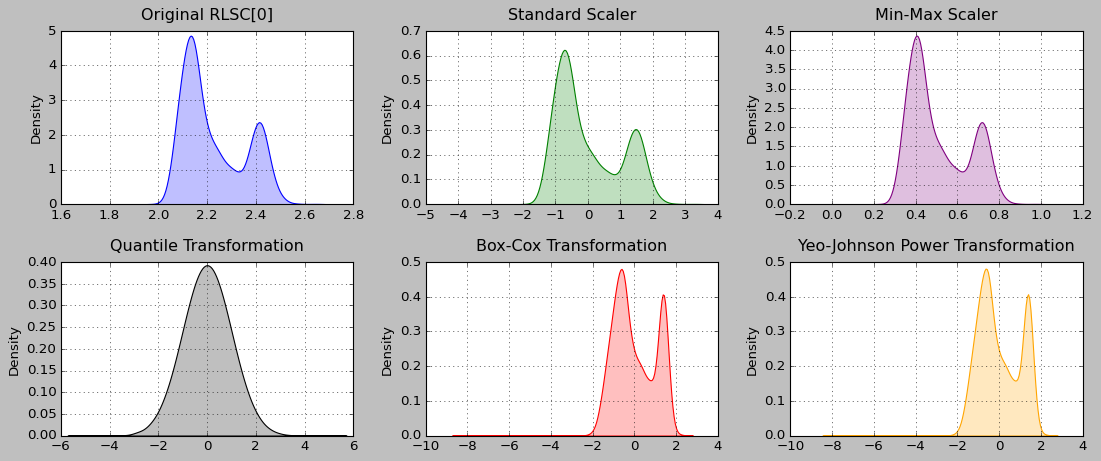

In [ ]:
scaler = [StandardScaler(), MinMaxScaler(), QuantileTransformer(output_distribution="normal"), 
          PowerTransformer(method="box-cox"), PowerTransformer(method="yeo-johnson")]
scaler_name = ["Standard Scaler", "Min-Max Scaler", "Quantile Transformation",
               "Box-Cox Transformation", "Yeo-Johnson Power Transformation"]
color = ["green", "purple", "black", "red", "orange"]
feature = "RLSC[0]"

plt.figure(figsize=(14,6))

for i in range(6):
  x = lwd_df[feature].values
  plt.subplot(2,3,i+1)
  if i == 0:
    # Untransformed
    sns.kdeplot(x, fill=True)
    plt.title("Original {}".format(feature), pad=10)   
    plt.grid() 
  if i > 0 and i <= 5:
    # Transformation
    x = x.reshape(-1,1)
    f = scaler[i-1]
    xnorm = f.fit_transform(x)
    xnorm = xnorm.reshape(-1)  

    sns.kdeplot(xnorm, color=color[i-1], fill=True)
    plt.title(scaler_name[i-1], pad=10)
    plt.grid()

plt.tight_layout(1.3)
plt.show()  

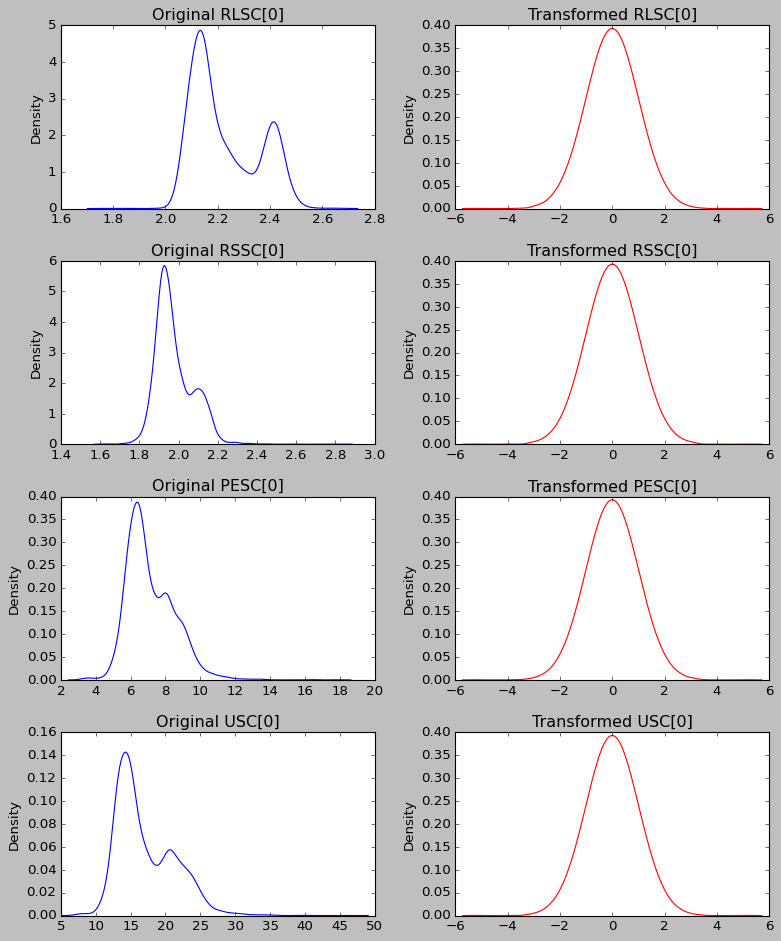

In [ ]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, QuantileTransformer, normalize

plt.figure(figsize=(10,12))

features = ["RLSC[0]", "RSSC[0]", "PESC[0]", "USC[0]"]
features = np.repeat(features, 2)

for i in range(8):
  plt.subplot(4,2,i+1)
  x = lwd_df[features[i]].values
  if (i % 2) == 0:
    # Even, left plots (original)
    sns.kdeplot(x, color="blue")
    plt.title("Original {}".format(features[i]))
  else:
    # Odd, right plots (Transformed)
    f = QuantileTransformer(output_distribution='normal')
    # f = StandardScaler()
    x = x.reshape(-1,1)
    xnorm = f.fit_transform(x)
    xnorm = xnorm.reshape(-1)

    sns.kdeplot(xnorm, color="red")
    plt.title("Transformed {}".format(features[i]))

plt.tight_layout(1.3)
plt.show()

## Machine learning pipeline

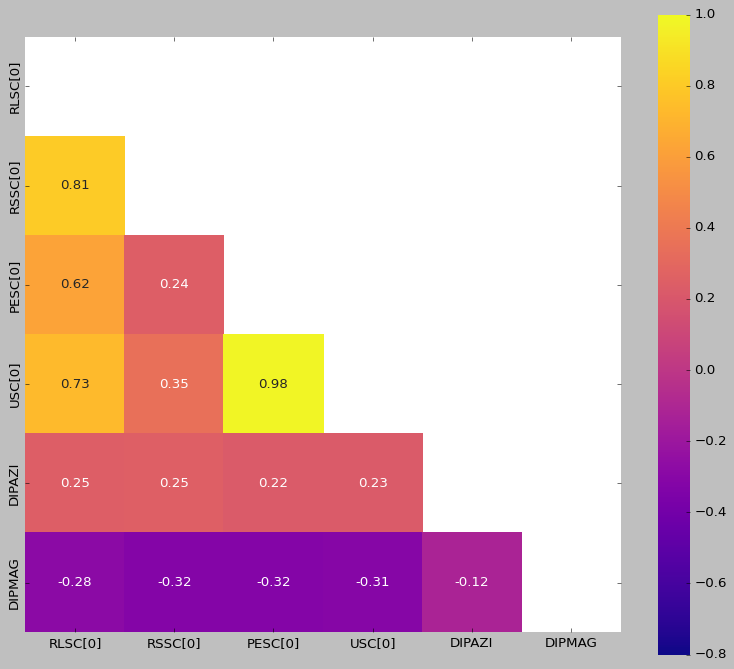

In [ ]:
features = np.ndarray.flatten(np.array(logs))
well_train_only_features = df[['RLSC[0]', 'RSSC[0]', 'PESC[0]', 'USC[0]', 'DIPAZI', 'DIPMAG']]
# well_train_only_features = df[['RLSC[15]', 'RSSC[15]', 'PESC[15]', 'USC[15]', 'DIPAZI', 'DIPMAG']]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
# cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)
cmap = 'plasma'

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmin=-.8, vmax=1, square=True)

plt.show()

In [ ]:
X, y = df.iloc[:,3:].values, df.DIPAZI.values

# Create pipeline
pipeline = make_pipeline(QuantileTransformer(output_distribution="normal"), RandomForestRegressor())

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (281). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


0.32578843886229814

In [ ]:
pipeline.score(X_test, y_test)

-0.07710236353813293

In [ ]:
y_pred

array([242.73957364, 183.71440993, 206.71931252,  20.03461833,
        81.60591967, 122.53279594,  58.97302181, 203.15842758,
        59.78312681, 202.66288046, 187.46083284,  46.64638226,
        58.56885888,  57.48567836,  48.88646364,  57.15347416,
       243.22853597, 176.35599224, -27.34287515, 169.55390658,
       180.24337989,  81.135282  , 215.18806921, 138.84618707,
       206.29006686, 229.74307607,  75.79635196, 142.24694978,
       265.5490767 , 170.22005936, 377.34700509, 102.56660723,
       238.17084288, 137.19864356, 169.41801815, 154.37983785,
       101.38457559,  69.1523634 ,  71.88894189,  57.1028021 ,
        42.00231358, 208.74294889, 244.80753856, 210.29757729,
       156.56669842, 245.91943109, 215.93064157, 128.85202073,
        37.97559097, 215.95964214, 160.74833835, 118.57867982,
       216.78024158, -33.45301781, 131.40758201, 228.73754759,
       199.65698877,  99.77014122, 198.19070303, 172.89955328,
       121.69482251,  82.4152694 ,  68.54299843,  88.78

In [ ]:
pipeline = make_pipeline(QuantileTransformer(output_distribution="normal"), LinearRegression())

pipeline

Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
steps = [('scaler', QuantileTransformer(output_distribution="normal")),
         ('elasticnet', ElasticNet())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters, cv=3)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))